In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import os
import h5py as hdf
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
def gather_universal(path: str,filetype: str)-> list:
    subdir=path

    data=[]
    for path, subdirs, files in os.walk(subdir):
        for name in files:
            if name.endswith(filetype) and name[-5]!='t'  :

                b=(str(os.path.join(path, name)))
                data.append(b)
    return data
def sort_on_last(list:list)->list:
    df=pd.DataFrame({'list': list})
    df['nums']=df['list'].apply(lambda x:x.split('_')[-1].split('.')[0])
    df['nums']=df.nums.astype(int)
    df.sort_values(by='nums',inplace=True)
    #display(df)
    return(np.array(df['list']))
path='data/hdf/'
display(gather_universal(path,'.hdf5'))

def get_hdf_main_groups(path) -> list:
    with hdf.File(path,'r') as r:
        #display([str(i) for i in r.keys()])
        return [str(i) for i in r.keys()]

def get_hdf_group_datasets(path,groupkey) -> list:
    with hdf.File(path,'r') as r:
        #display([str(i) for i in r[groupkey].keys()])
        return [str(i) for i in r[groupkey].keys()]

def get_df_columns(path)-> pd.DataFrame:
    groups=get_hdf_main_groups(path)
    cols=[]
    for key in groups:
       cols=cols+ list(zip(list(np.full(len(get_hdf_group_datasets(path,key)),key)),
                 get_hdf_group_datasets(path,key)))

    #display(cols)
    columns=pd.MultiIndex.from_tuples(cols, names=('group', 'dataset'))
    #display(pd.DataFrame(columns=columns))
    return columns
def zero_to_nan(array):
    array[array==0.]=np.nan
    return(array)
def steps_to_df(seriespath,examplefilepath)->pd.DataFrame:
    path=seriespath
    series=pd.DataFrame(index=sort_on_last(gather_universal(path,'.hdf5')),columns=get_df_columns(examplefilepath))

    for file in series.index:
        with hdf.File(str(file),'r') as r:
            for location in series.columns:
                series.loc[file,location]=r[location[0]][location[1]][:]
    return series
series=steps_to_df('Y:\Istra Repositories\ch-gr_exports\MC_A_8yi','data/hdf/series_step_115.hdf5')


['data/hdf/series_step_104.hdf5',
 'data/hdf/series_step_105.hdf5',
 'data/hdf/series_step_106.hdf5',
 'data/hdf/series_step_113.hdf5',
 'data/hdf/series_step_114.hdf5',
 'data/hdf/series_step_115.hdf5',
 'data/hdf/series_step_122.hdf5',
 'data/hdf/series_step_123.hdf5',
 'data/hdf/series_step_124.hdf5',
 'data/hdf/series_step_131.hdf5']

In [3]:
def isnotnan(num):
    return num == num
def linefit(x,y):
    coeffs=np.polyfit(x,y,1)
    poly=np.poly1d(coeffs)
    newy=poly(x)
    return newy

def strip_background(array):
    df=pd.DataFrame(array)
    #before=array
    #bf=plt.matshow(before)
    #plt.colorbar(bf)

    after=df.copy()
    after[after==0.]=np.nan
    #display(after)

    after.dropna(how='all',axis=0,inplace=True)
    after.dropna(how='all',axis=1,inplace=True)
    #display(after)
    """af=plt.matshow(after.dropna(how='all',axis=0))
    plt.colorbar(af)"""
    #display(after)
    return(after)

def get_line(df):
    afters=df.copy()
    for column in afters.columns:
        for row in afters.index:
            if isnotnan(afters.loc[row,column]) :
                afters.loc[row,column]=row
    coeffs=np.polyfit(afters.columns,afters.mean(axis=0,skipna=True),1)
    return coeffs

def get_scan_range(df,slope):
    xmin=df.columns.min()
    xmax=df.columns.max()
    ymin=df.index.min()
    ymax=df.index.max()
    pairs=[(xmin,ymin),(xmin,ymax),(xmax,ymin),(xmax,ymax)]
    #display(pairs)
    ts=[pair[1]-(slope*pair[0]) for pair in pairs]
    return (round(min(ts)),round(max(ts)))

def create_striper(stripped_background:pd.DataFrame):
    after=stripped_background
    scan_range=get_scan_range(after,get_line(after)[0])
    scan_range=range(*scan_range,1)
    res=pd.DataFrame(columns=after.columns,index=scan_range)
    #display(res)
    m=get_line(after)[0]
    for t in res.index:
        for x in res.columns:
            res.loc[t,x]=math.ceil((m*x)+t)
        #display(res.loc[t,:].dtypes)
    for column in res:
        res[column]=res[column].astype(int)
    return res
def apply_striper(striper,original_array):
    array=original_array
    res=striper

    #res.reset_index(inplace=True,drop=True)

    #display(min(after.index),max(after.index))
    striped=res.loc[range(min(after.index),max(after.index)+1),:].copy()
    #display(striped,after.index)

    #display(striped)
    array=pd.DataFrame(array)
    #display(array)
    for column in striped.columns:

        for index in striped.index:

            striped.loc[index,column]=array.loc[striped.loc[index,column],column]
    #display(striped)
    striped[striped == 0.]=np.nan
    return striped

In [4]:
import scipy as scipy
import scipy.signal as sgy
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0

    if  window_size % 2 == 0:
        window_size=window_size+1
        #raise ValueError('window_size must be odd')

    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2

    # exponents of the polynomial.
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ...
    # this line gives a list of two item tuple. Each tuple contains
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]

    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])

    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band )
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z

    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band )

    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band )
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band )

    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        """d1=pd.DataFrame(np.linalg.pinv(A)[1].reshape((window_size, -1)))
        d2=pd.DataFrame(np.linalg.pinv(A)[2].reshape((window_size, -1)))
        p=pd.DataFrame(m)
        display(p,p.shape,d1,d1.shape)
        fig,[a,b,c]=plt.subplots(1,3,figsize=(20,15))
        a.matshow(p, label='strain')
        b.matshow(d1,label='strain')
        c.matshow(d2,label='strain')

        X,Y=np.meshgrid(p.columns,p.index)
        fig = plt.figure(figsize=[20,15])
        ax = fig.gca(projection='3d')
        axis = ax.plot_surface(X,Y,p, cmap=cm.viridis,linewidth=5, antialiased=False)
        ax.view_init(30,-50)
        plt.colorbar(axis)"""

        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')

In [5]:
def perform_display(array):
    after=strip_background(array)
    res=create_striper(after)
    striped=apply_striper(res,array)
    """plt.matshow(striped)
    imf=plt.matshow((sgolay2d(striped.fillna(0).values,5,3)),cmap='plasma')

    plt.colorbar(imf)"""
    display(striped.shape)
    return striped.fillna(0)

def get_endsize(df):
    after=strip_background(df)
    #display(after)
    return (after.index[0],after.index[-1]),(after.columns[0],after.columns[-1])
def get_measure_length(df,col1,col2):
    mean_col1=df.loc[:,col1].mean()
    mean_col2=df.loc[:,col2].mean()
    return mean_col2-mean_col1

def get_macro_strain(current_df,reference_df):
    size=get_endsize(current_df)
    l_0=get_measure_length(reference_df,size[1][0],size[1][1])
    l=get_measure_length(current_df,size[1][0],size[1][1])
    dl=l-l_0
    return dl/l_0


def counter(df,sections):
    df=df.unstack().reset_index()
    df.columns=['X','Y','Z']
    resdict={}
    for i in range(len(sections)-1):
        resdict[sections[i]]=len(df[(df['Z']<=sections[i+1]) & (df['Z']>=sections[i])])
    #display(resdict)
    return(resdict)


In [6]:
base=steps_to_df('Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi','Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi/series_step_115.hdf5')

In [7]:
display(base)


group                                                                add_data  \
dataset                                                       analog_channels   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...   [[0.001815607360128077]]   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...   [[0.001815607360128077]]   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0021444108650868904]]   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...    [[0.00148680385520851]]   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...    [[0.00148680385520851]]   
...                                                                       ...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...   [[0.003130821380199253]]   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...   [[0.003130821380199253]]   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0028020178751224506]]   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0024732143700850195]]   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...   [[0.003130821380199253]]   

group                                                                                     coordinates  \
dataset                                                                                  coordinate_x   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                                               ...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

group                                                                                                  \
dataset                                                                              coordinate_x_var   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                                               ...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_GW_8xi\s...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

group                                                                                                  \
dataset                                                                                  coordinate_y   
Y:\I

In [8]:
def get_selection (df,col,step):
    arrays=df.iloc[1::step,:][col]
    brays=arrays.apply(strip_background)
    return brays
brays=get_selection(base,('strains','strain_p1'),50)
def mean_var_plot(df):
    mean=[np.nanmean(val.values) for val in df]
    var=[np.nanvar(val.values) for val in df]
    plt.plot(var)
    #plt.errorbar(range(len(mean)),mean,yerr=var)
    plt.show()

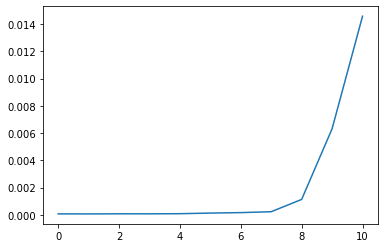

In [9]:
brays=get_selection(base,('strains','strain_p1'),50)
mean_var_plot(brays)

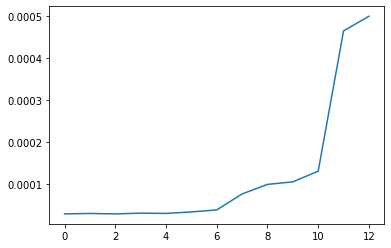

In [10]:
brays=get_selection(series,('strains','strain_p1'),50)
mean_var_plot(brays)

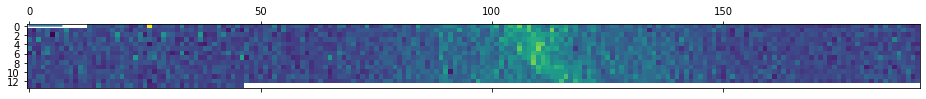

In [11]:
MC_A_6xiii=steps_to_df('Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii','Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii/series_step_115.hdf5')
brays=get_selection(MC_A_6xiii,('strains','strain_p1'),25)
plt.matshow(brays[5])
mean_var_plot(brays)

group                                                               add_data  \
dataset                                                      analog_channels   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.006418856433135847]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.005761249422232481]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.005761249422232481]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.005761249422232481]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.005432445916840153]]   
...                                                                      ...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...    [[2.2478745166229563]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...    [[2.2399832129400883]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...     [[2.230447887809939]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...    [[2.2189397370134607]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...    [[2.1978962618979745]]   

group                                                                                     coordinates  \
dataset                                                                                  coordinate_x   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                                               ...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

group                                                                                                  \
dataset                                                                              coordinate_x_var   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                                               ...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii\...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

group                                                                                                  \
dataset                                                                                  coordinate_y   
Y:\Istra Reposito

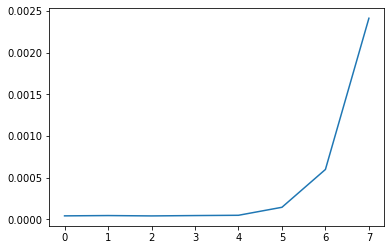

In [12]:
display(MC_A_6xiii)
mean_var_plot(brays)

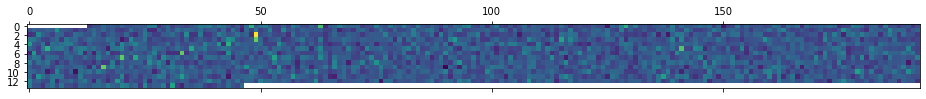

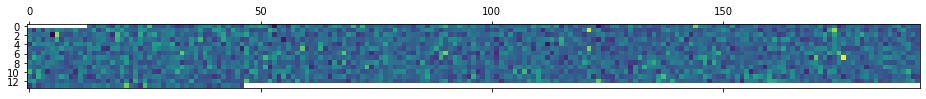

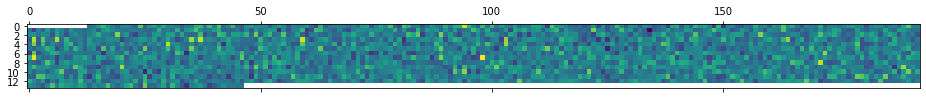

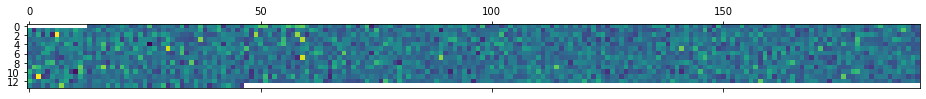

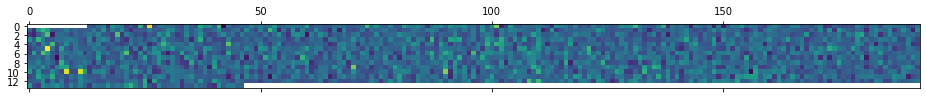

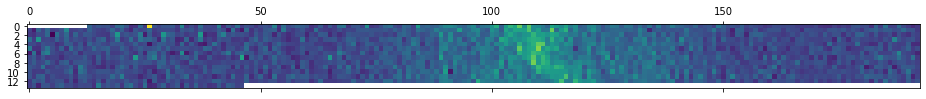

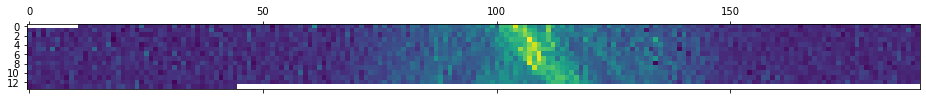

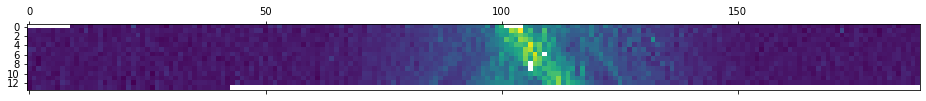

In [13]:
for val in brays:
    plt.matshow(val)

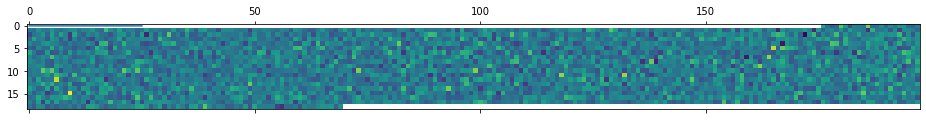

In [19]:
MC_A_8xi=steps_to_df('Y:\Istra Repositories\ch-gr_exports\MC_A_8xi','Y:\Istra Repositories\ch-gr_exports\MC_A_8xi/series_step_115.hdf5')
brays=get_selection(MC_A_8xi,('strains','strain_p1'),25)
plt.matshow(brays[5])
mean_var_plot(brays)

group                                                               add_data  \
dataset                                                      analog_channels   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.012994926550912042]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.012337319538416283]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.012994926550912042]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.012666123044644137]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.012337319538416283]]   
...                                                                      ...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.004774838906174042]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.005432445916840153]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.005103642411487336]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.004446035400900203]]   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.005103642411487336]]   

group                                                                                     coordinates  \
dataset                                                                                  coordinate_x   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                                               ...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

group                                                                                                  \
dataset                                                                              coordinate_x_var   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                                               ...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\se...  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

group                                                                                                  \
dataset                                                                                  coordinate_y   
Y:\Istra Reposito

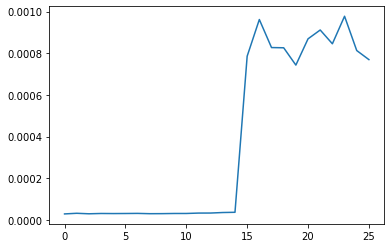

In [20]:
display(MC_A_8xi)
mean_var_plot(brays)

<ipython-input-21-337ab0009e7b>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.matshow(val)


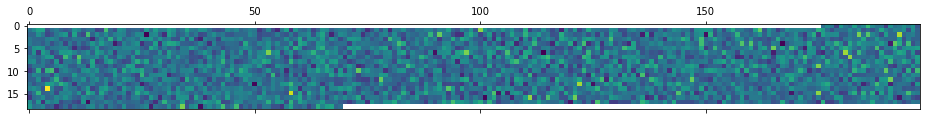

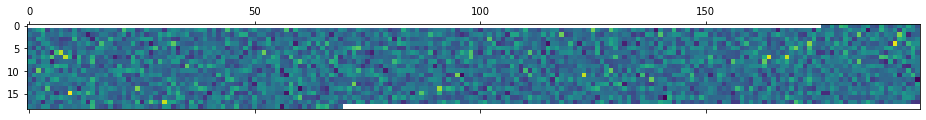

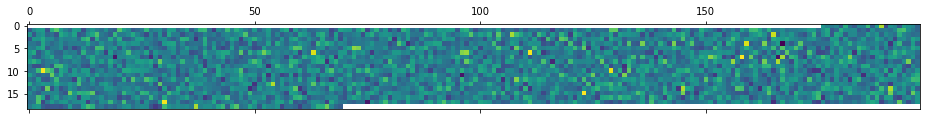

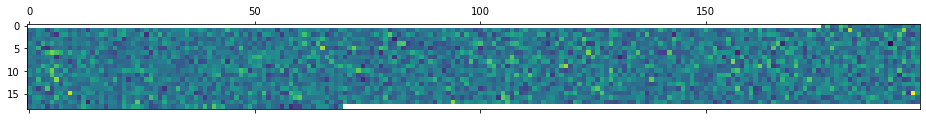

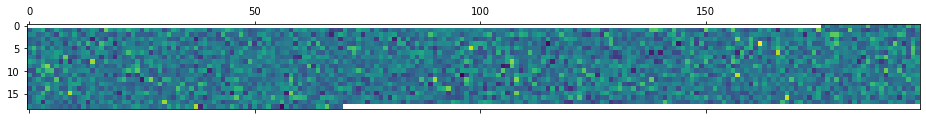

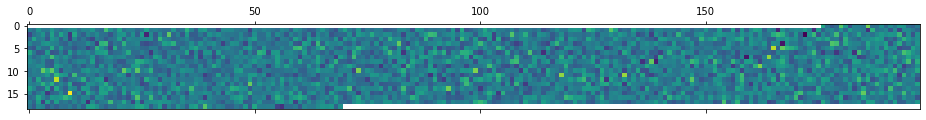

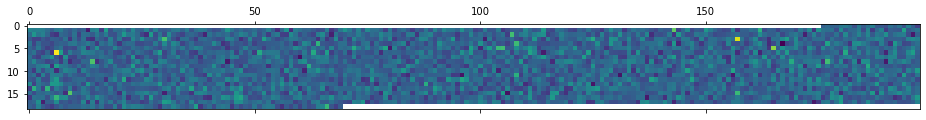

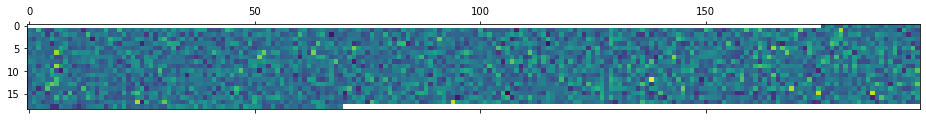

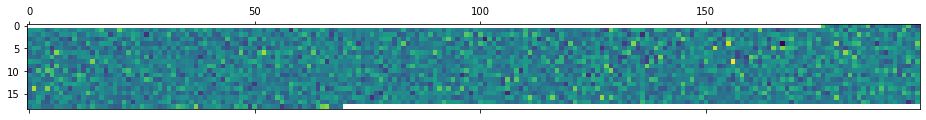

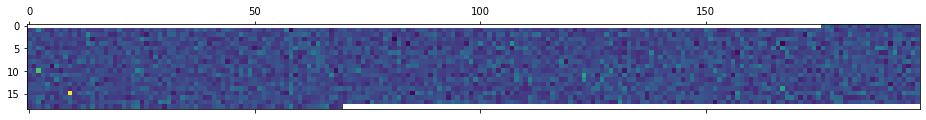

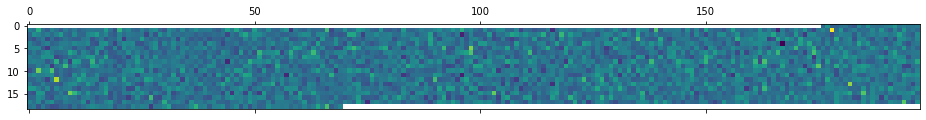

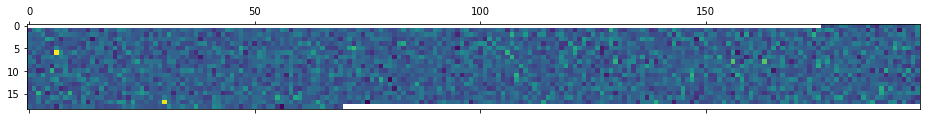

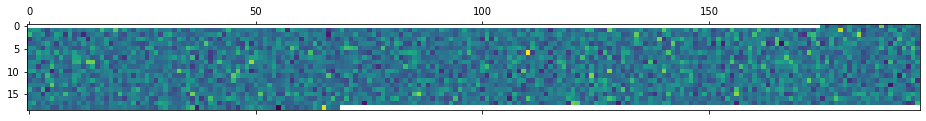

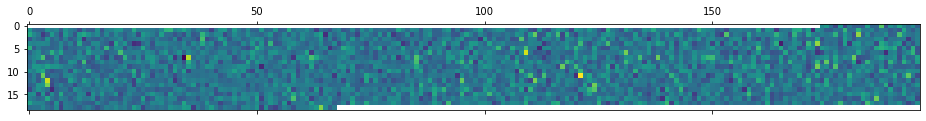

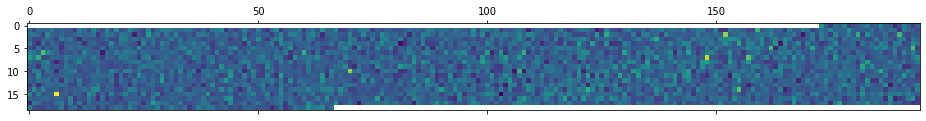

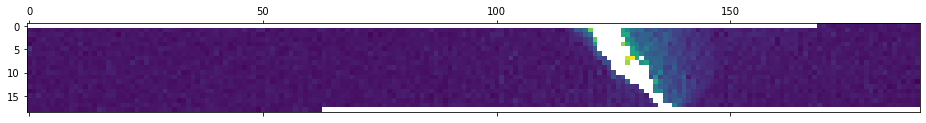

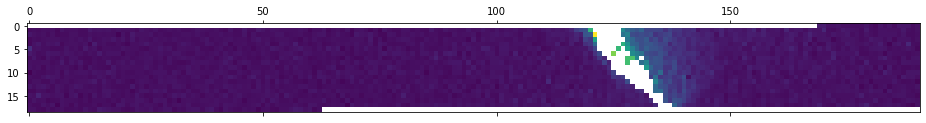

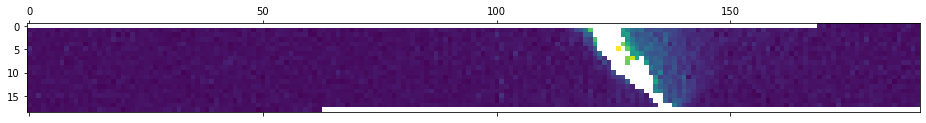

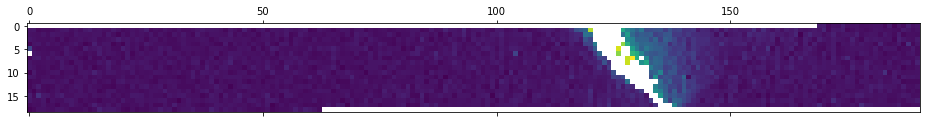

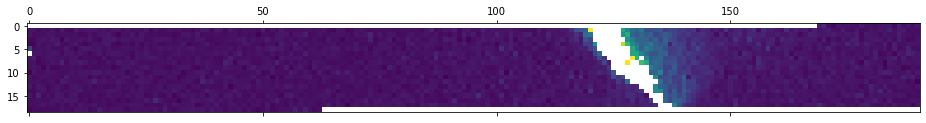

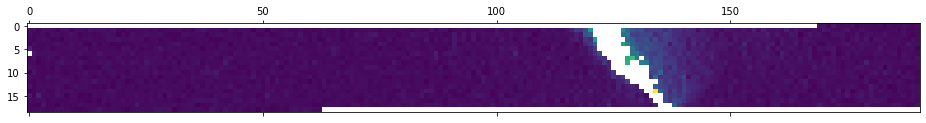

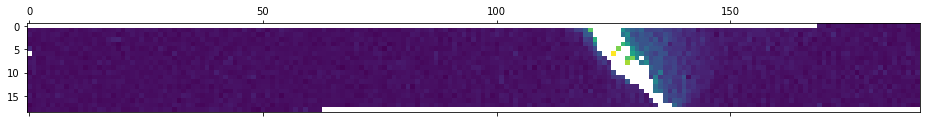

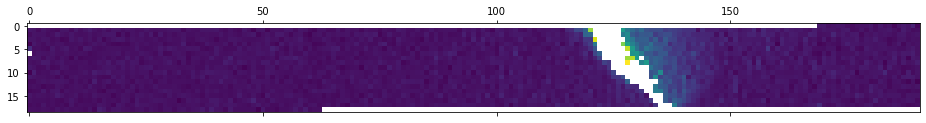

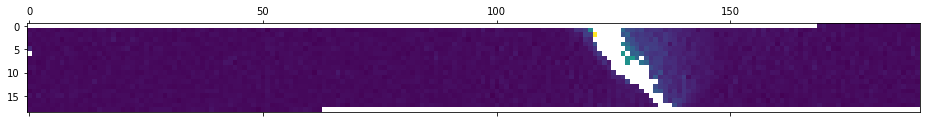

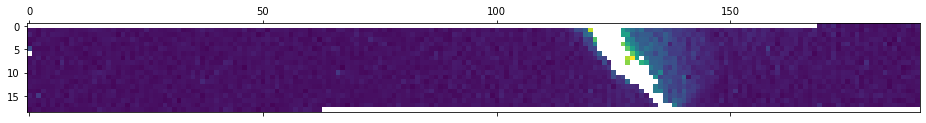

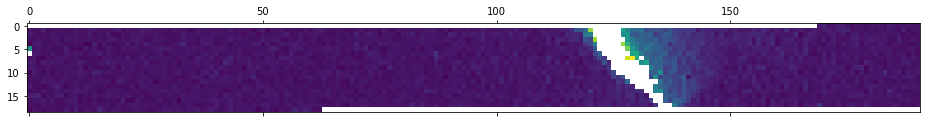

In [21]:
for val in brays:
    plt.matshow(val)

In [22]:
display(brays)


Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\series_step_1.hdf5               2         3         4         5      ...
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\series_step_26.hdf5              2         3         4         5      ...
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\series_step_51.hdf5              2         3         4         5      ...
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\series_step_76.hdf5              2         3         4         5      ...
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\series_step_101.hdf5             2         3         4         5      ...
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\series_step_126.hdf5             2         3         4         5      ...
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\series_step_151.hdf5             2         3         4         5      ...
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\series_step_176.hdf5             2         3         4         5      ...
Y:\Istra Repositories\ch-gr_exports\MC_A_8xi\ser